In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (cluster_utils,
                                            portfolio_utils as portfolio,
                                            lstm)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '1995-01-01'
date_end = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 30
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,ACY,1999-09-20 05:00:00,7.250000
1,AA,1999-09-20 05:00:00,97.968753
2,ABT,1999-09-20 05:00:00,20.575147
3,ABM,1999-09-20 05:00:00,11.062500
4,AB,1999-09-20 05:00:00,27.000000


### Clean data

In [3]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [4]:
df['open_denormalized'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [5]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

In [6]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(18150, 123)


,symbol,market_datetime,open,open_denormalized,open_min,open_max,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
12236,ABT,2004-02-03 06:00:00,0.496197,20.910091,14.354754,27.565912,0,0,0,0,...,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950,0.486001
12238,ABM,2004-02-03 06:00:00,0.817239,17.820000,10.531250,19.450000,0,0,0,0,...,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653,0.514832
12241,ABEV,2004-02-03 06:00:00,0.774504,0.978800,0.432000,1.138000,0,0,0,0,...,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419,0.708215
12242,AB,2004-02-03 06:00:00,0.412857,37.950000,23.500000,58.500000,0,0,0,0,...,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143,0.302286
12243,AA,2004-02-03 06:00:00,0.574561,101.160000,54.000000,136.080000,0,1,0,0,...,0.354532,0.357091,0.362939,0.390351,0.365497,0.364035,0.381944,0.417763,0.374635,0.380117
12249,ABC,2004-02-03 06:00:00,0.620840,13.840000,3.078125,20.412500,0,0,0,0,...,0.617551,0.610050,0.606511,0.598018,0.644020,0.658882,0.672328,0.676999,0.666384,0.670913
12252,ABT,2004-02-04 06:00:00,0.516117,21.173262,14.354754,27.565912,0,0,0,0,...,0.432520,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950
12254,ABM,2004-02-04 06:00:00,0.825088,17.890000,10.531250,19.450000,0,0,0,0,...,0.473698,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653
12255,ABEV,2004-02-04 06:00:00,0.773371,0.978000,0.432000,1.138000,0,0,0,0,...,0.592635,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419
12256,AB,2004-02-04 06:00:00,0.410000,37.850000,23.500000,58.500000,0,0,0,0,...,0.347143,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143


### Train lstm

In [7]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'open_denormalized']

data_size = int(round(len(train_test)/2, -2))

train = train_test.head(data_size)
test = train_test.tail(int(data_size/2))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Batch 1, Epoch 0, Loss 6229.74609375
Batch 1, Epoch 50, Loss 850.975341796875
Batch 1, Epoch 100, Loss 686.7882080078125
Batch 1, Epoch 150, Loss 544.79931640625
Batch 1, Epoch 200, Loss 417.3665771484375
Batch 1, Epoch 250, Loss 356.3275146484375
Batch 1, Epoch 300, Loss 319.2159423828125
Batch 1, Epoch 350, Loss 296.8530578613281
Batch 1, Epoch 400, Loss 275.9696960449219
Batch 1, Epoch 450, Loss 262.4941101074219


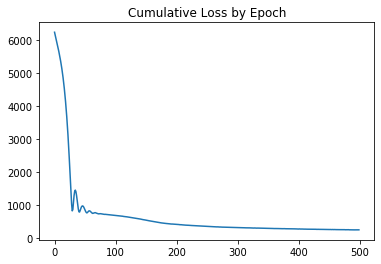

In [8]:
model = lstm.TorchLSTM(
    train_x=train.drop(cols_to_ignore, axis=1),
    train_y=train['open'],
    test_x=test.drop(cols_to_ignore, axis=1),
    test_y=test['open'],
    n_layers=2,
    n_training_batches=1,
    n_epochs=500,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=6
)

model.fit()
prediction = model.prediction_df

In [9]:
res = test[cols_to_ignore].join(prediction)
res.head()

,symbol,market_datetime,open,open_min,open_max,open_denormalized,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99,prediction
33506,ACN,2008-11-10 06:00:00,0.427865,21.00,43.25,30.52,0,0,0,0,...,0.870562,0.846292,0.912809,0.855730,0.806292,0.817978,0.806292,0.829663,0.828764,0.454102
33505,ABM,2008-11-10 06:00:00,0.167956,13.10,31.20,16.14,0,0,0,0,...,0.401329,0.384053,0.351495,0.438538,0.460465,0.491030,0.487708,0.508306,0.490365,0.199666
33511,ABB,2008-11-10 06:00:00,0.272792,5.34,33.31,12.97,0,0,0,0,...,0.813380,0.796831,0.825704,0.827817,0.827465,0.833099,0.878873,0.908451,0.908451,0.286667
33540,ABB,2008-11-11 06:00:00,0.223454,5.34,33.31,11.59,0,0,0,0,...,0.790845,0.813380,0.796831,0.825704,0.827817,0.827465,0.833099,0.878873,0.908451,0.290085
33539,ACY,2008-11-11 06:00:00,0.418696,2.10,25.10,11.73,0,0,0,0,...,0.473478,0.605652,0.701304,0.661304,0.587391,0.548261,0.484783,0.467826,0.391304,0.409119


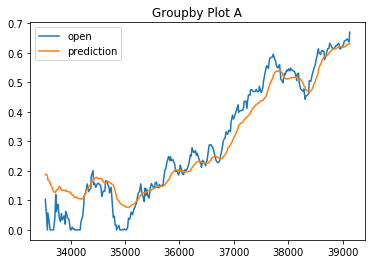

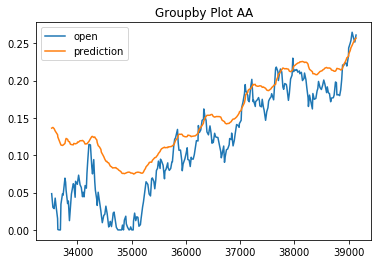

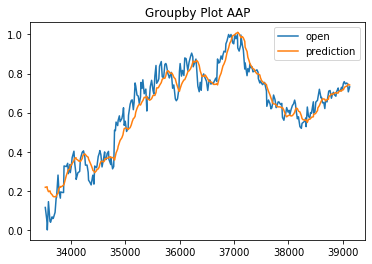

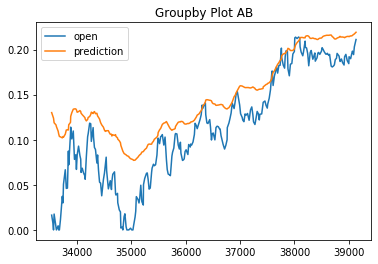

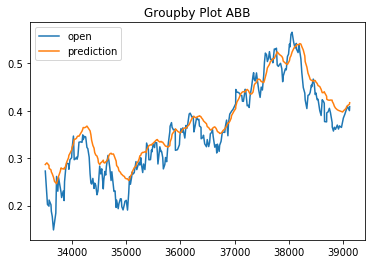

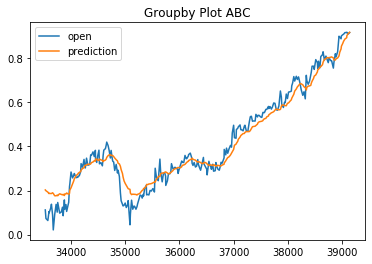

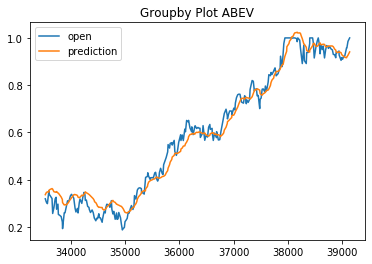

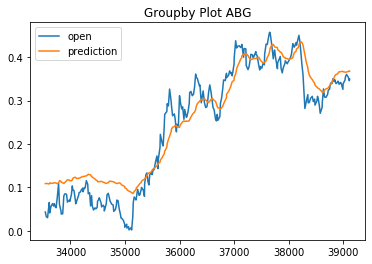

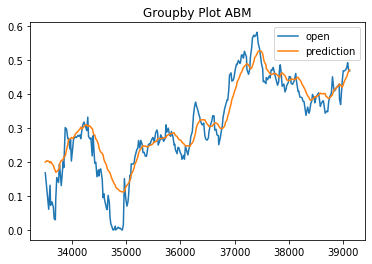

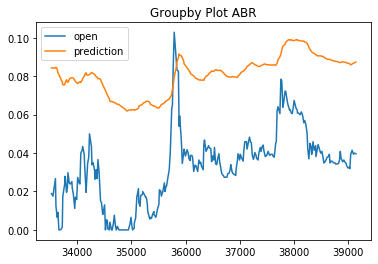

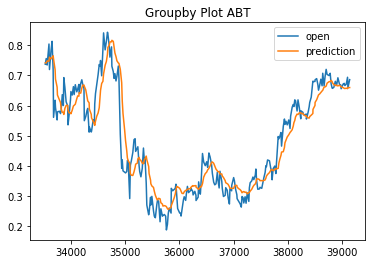

In [10]:
cluster_utils.plot_groupby(res, 'symbol', lines=['open', 'prediction'])

In [11]:
# Calculate prior price and prediction
res['open_denormalized_prior'] = (res['open_1'] * (res['open_max'] - res['open_min'])) + res['open_min']
res['open_prediction'] = (res['prediction'] * (res['open_max'] - res['open_min'])) + res['open_min']
res['profit_prediction'] = abs(res['open_prediction'] - res.groupby('symbol').shift()['open_denormalized'])

# Determine trade directions
res['trade'] = 'neutral'
res.loc[res['prediction'] > res['open_1'], 'trade'] = 'long'
res.loc[res['prediction'] < res['open_1'], 'trade'] = 'short'

# Calculate profits
res['profit_denormalized'] = 0
res.loc[res['trade']=='long', 'profit_denormalized'] = res['open_denormalized'] - res['open_denormalized_prior']
res.loc[res['trade']=='short', 'profit_denormalized'] = res['open_denormalized_prior'] - res['open_denormalized']

res[['market_datetime', 'symbol', 'open', 'prediction', 'open_denormalized', 
     'open_denormalized_prior', 'open_prediction', 'profit_prediction', 'profit_denormalized', 'trade']].tail(10)

,market_datetime,symbol,open,prediction,open_denormalized,open_denormalized_prior,open_prediction,profit_prediction,profit_denormalized,trade
39126,2009-12-31 06:00:00,AAP,0.731940,0.741278,41.110000,40.550000,41.315518,0.765518,0.560000,long
39128,2009-12-31 06:00:00,A,0.670032,0.631409,22.203147,21.537911,21.437025,0.100886,-0.665236,short
39127,2009-12-31 06:00:00,ABM,0.467876,0.471286,20.930000,20.980000,20.995825,0.015825,-0.050000,long
39125,2009-12-31 06:00:00,ACC,0.669734,0.663205,28.450000,28.140000,28.322296,0.182296,0.310000,long
39123,2009-12-31 06:00:00,ABB,0.408688,0.416947,19.290000,19.090000,19.485807,0.395807,0.200000,long
39121,2009-12-31 06:00:00,ABG,0.349342,0.367662,11.770000,11.670000,12.284976,0.614976,0.100000,long
39120,2009-12-31 06:00:00,ACY,0.567568,0.595217,15.500000,15.830000,16.113816,0.283816,-0.330000,long
39138,2009-12-31 06:00:00,AA,0.260900,0.256785,48.989997,47.790000,48.463385,0.673385,1.199997,long
39129,2009-12-31 06:00:00,ACU,0.338742,0.329710,9.250000,9.420000,9.160944,0.259056,0.170000,short
39139,2009-12-31 06:00:00,ABR,0.039654,0.087345,1.760000,1.770000,3.359536,1.589536,-0.010000,long


In [12]:
kwargs = {"profits": 'profit_denormalized'} 
res = res.groupby('symbol').apply(portfolio.get_estimated_loss, **kwargs)

res['kelly'] = portfolio.kelly_criterion(res['profit_prediction'], 
                                         res['estimated_loss'], 
                                         res['profit_rate'])

res = res.dropna()
res.tail(10)

,symbol,market_datetime,open,open_min,open_max,open_denormalized,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_99,prediction,open_denormalized_prior,open_prediction,profit_prediction,trade,profit_denormalized,profit_rate,estimated_loss,kelly
39126,AAP,2009-12-31 06:00:00,0.731940,25.000000,47.010000,41.110000,0,0,1,0,...,0.944571,0.741278,40.550000,41.315518,0.765518,long,0.560000,0.56,0.410000,0.324343
39128,A,2009-12-31 06:00:00,0.670032,8.912732,28.748212,22.203147,1,0,0,0,...,0.405698,0.631409,21.537911,21.437025,0.100886,short,-0.665236,0.47,0.157368,-0.356728
39127,ABM,2009-12-31 06:00:00,0.467876,11.900000,31.200000,20.930000,0,0,0,0,...,0.514508,0.471286,20.980000,20.995825,0.015825,long,-0.050000,0.58,0.200000,-4.728072
39125,ACC,2009-12-31 06:00:00,0.669734,15.350000,34.910000,28.450000,0,0,0,0,...,0.546012,0.663205,28.140000,28.322296,0.182296,long,0.310000,0.58,0.330000,-0.180301
39123,ABB,2009-12-31 06:00:00,0.408688,9.600000,33.310000,19.290000,0,0,0,0,...,0.420213,0.416947,19.090000,19.485807,0.395807,long,0.200000,0.49,0.260000,0.154988
39121,ABG,2009-12-31 06:00:00,0.349342,1.950000,30.060000,11.770000,0,0,0,0,...,0.429385,0.367662,11.670000,12.284976,0.614976,long,0.100000,0.60,0.260000,0.430888
39120,ACY,2009-12-31 06:00:00,0.567568,2.900000,25.100000,15.500000,0,0,0,0,...,0.368919,0.595217,15.830000,16.113816,0.283816,long,-0.330000,0.44,0.414500,-0.377854
39138,AA,2009-12-31 06:00:00,0.260900,15.599997,143.580000,48.989997,0,1,0,0,...,0.173699,0.256785,47.790000,48.463385,0.673385,long,1.199997,0.57,0.885002,0.004869
39129,ACU,2009-12-31 06:00:00,0.338742,5.910000,15.770000,9.250000,0,0,0,0,...,0.184783,0.329710,9.420000,9.160944,0.259056,short,0.170000,0.51,0.090000,0.339766
39139,ABR,2009-12-31 06:00:00,0.039654,0.430000,33.970000,1.760000,0,0,0,0,...,0.044723,0.087345,1.770000,3.359536,1.589536,long,-0.010000,0.42,0.060000,0.398107


In [13]:
positions, budget = portfolio.greedy_kelly(res, price='open_denormalized_prior', profits='profit_denormalized')

Annualized P/L 4.017803


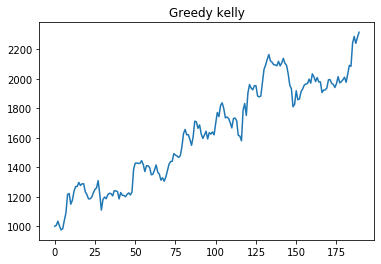

,symbol,market_datetime,open,open_min,open_max,open_denormalized,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_denormalized_prior,open_prediction,profit_prediction,trade,profit_denormalized,profit_rate,estimated_loss,kelly,position,n_shares
35377,ACN,2009-04-03 05:00:00,0.310562,21.000000,43.250000,27.910000,0,0,0,0,...,27.73000,29.346328,1.616328,long,0.180000,0.56,0.550000,0.410278,388.2200,14
35385,ABM,2009-04-03 05:00:00,0.226943,11.900000,31.200000,16.280000,0,0,0,0,...,16.08000,16.617771,0.537771,long,0.200000,0.51,0.310000,0.227538,225.1200,14
35414,ABR,2009-04-06 05:00:00,0.009541,0.430000,33.970000,0.750000,0,0,0,0,...,0.70000,2.593715,1.893715,long,0.050000,0.42,0.115000,0.384778,386.4000,552
35404,ACN,2009-04-06 05:00:00,0.314607,21.000000,43.250000,28.000000,0,0,0,0,...,27.91000,29.257628,1.347628,long,0.090000,0.56,0.540000,0.383690,362.8300,13
35433,ABT,2009-04-07 05:00:00,0.238851,17.962582,29.121011,20.627781,0,0,0,0,...,20.98665,22.411948,1.425298,long,-0.358869,0.50,0.334944,0.382500,377.7597,18


In [14]:
annualized_return = portfolio.annualized_return(
    budget[0], 
    budget[-1], 
    len(budget))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Greedy kelly')
plt.plot(budget)
plt.show()

positions.head()

In [22]:
performance = portfolio.portfolio_performance(
    positions,
    profits='profit_denormalized',
    predicted_profits: str='profit_prediction',
    trade: str='trade',
)
performance.head()

,trade,position
market_datetime,,
2009-04-03 05:00:00,2,613.340000
2009-04-06 05:00:00,2,749.230000
2009-04-07 05:00:00,2,776.759700
2009-04-08 05:00:00,2,758.400058
2009-04-09 05:00:00,2,778.090000
...,...,...
2009-12-24 06:00:00,2,1863.600000
2009-12-28 06:00:00,2,1992.830000
2009-12-29 06:00:00,2,1966.700000
